In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
mobility_df = pd.read_csv('erasmus_data_clean.csv', sep=';',low_memory=False, header=0)
for i, name in enumerate(mobility_df.columns):
    print(i, name)

0 Sending Organization
1 Receiving Organization
2 Participants
3 Field of Education
4 Sending Country Code
5 Receiving Country Code


In [3]:
df_w_fields = mobility_df.copy()

In [4]:
mobility_df

,Sending Organization,Receiving Organization,Participants,Field of Education,Sending Country Code,Receiving Country Code
0,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,music and performing arts,AT,SE
1,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,environmental protection technology,UA,AT
2,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,electronics and automation,UA,AT
3,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,mechanics and metal trades,UA,AT
4,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,mining and extraction,AT,RU
...,...,...,...,...,...,...
234603,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,political sciences and civics,UK,RU
234604,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,political sciences and civics,UK,RU
234605,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,economics,RU,UK
234606,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,arts and humanities,UK,IL


In [5]:
print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))

Number of Receiving Universities:  3668
Number of Sending Universities:  4189


In [6]:
field_df = mobility_df.iloc[:,[3,2]].groupby(['Field of Education']).sum()
field_df.sort_values(by='Participants', inplace=True)
field_df

,Participants
Field of Education,
community sanitation,4
hygiene and occupational health services,8
care of the elderly and of disabled adults,10
hair and beauty services,11
domestic services,19
...,...
political sciences and civics,10388
engineering and engineering trades,12829
law,14242


In [25]:
node_df = mobility_df.iloc[:, [0,4]].groupby(['Sending Organization', 'Sending Country Code']).sum()
node_df.to_csv('nodes_universities.csv')
mob_df = mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1)
edges_df = mob_df.iloc[:,[0,1,2] ].groupby(['source', 'target']).sum()
edges_df
edges_df.to_csv('edges_universities.csv')
node_df

,
Sending Organization,Sending Country Code
"""ADA"" UNIVERSITY",AZ
"""FINANCIAL ACADEMY""",KZ
"""KATHOLISCHE STIFTUNGSHOCHSCHULE MÜNCHEN"" HOCHSCHULE FÜR ANGEWANDTE WISSENSCHAFTEN DER KIRCHLICHEN STIFTUNG DES ÖFFENTLICHEN RECHTS ""KATHOLISCHE BILDUNGSSTÄTTEN FÜR SOZIALBERUFE IN BAYERN""",DE
"""KROK"" UNIVERSITY",UA
''FRENCH UNIVERSITY IN ARMENIA'' FOUNDATION,AM
...,...
ÜSKÜDAR UNIVERSITY,TR
РОССИЙСКАЯ АКАДЕМИЯ НАРОДНОГО ХОЗЯЙСТВА И ГОСУДАРСТВЕННОЙ СЛУЖБЫ ПРИ ПРЕЗИДЕНТЕ РОССИЙСКОЙ ФЕДЕРАЦИИ,RU
РОССИЙСКИЙ ГОСУДАРСТВЕННЫЙ АГРАРНЫЙ УНИВЕРСИТЕТ - МСХА ИМЕНИ К.А. ТИМИРЯЗЕВА,RU


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

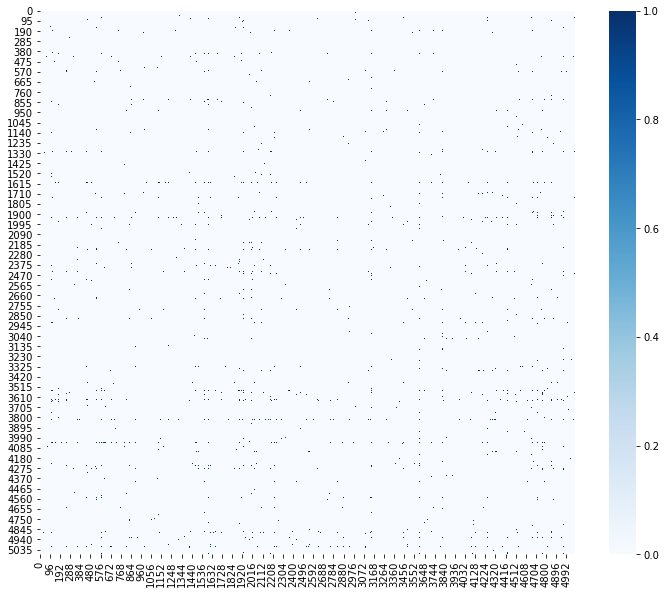

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

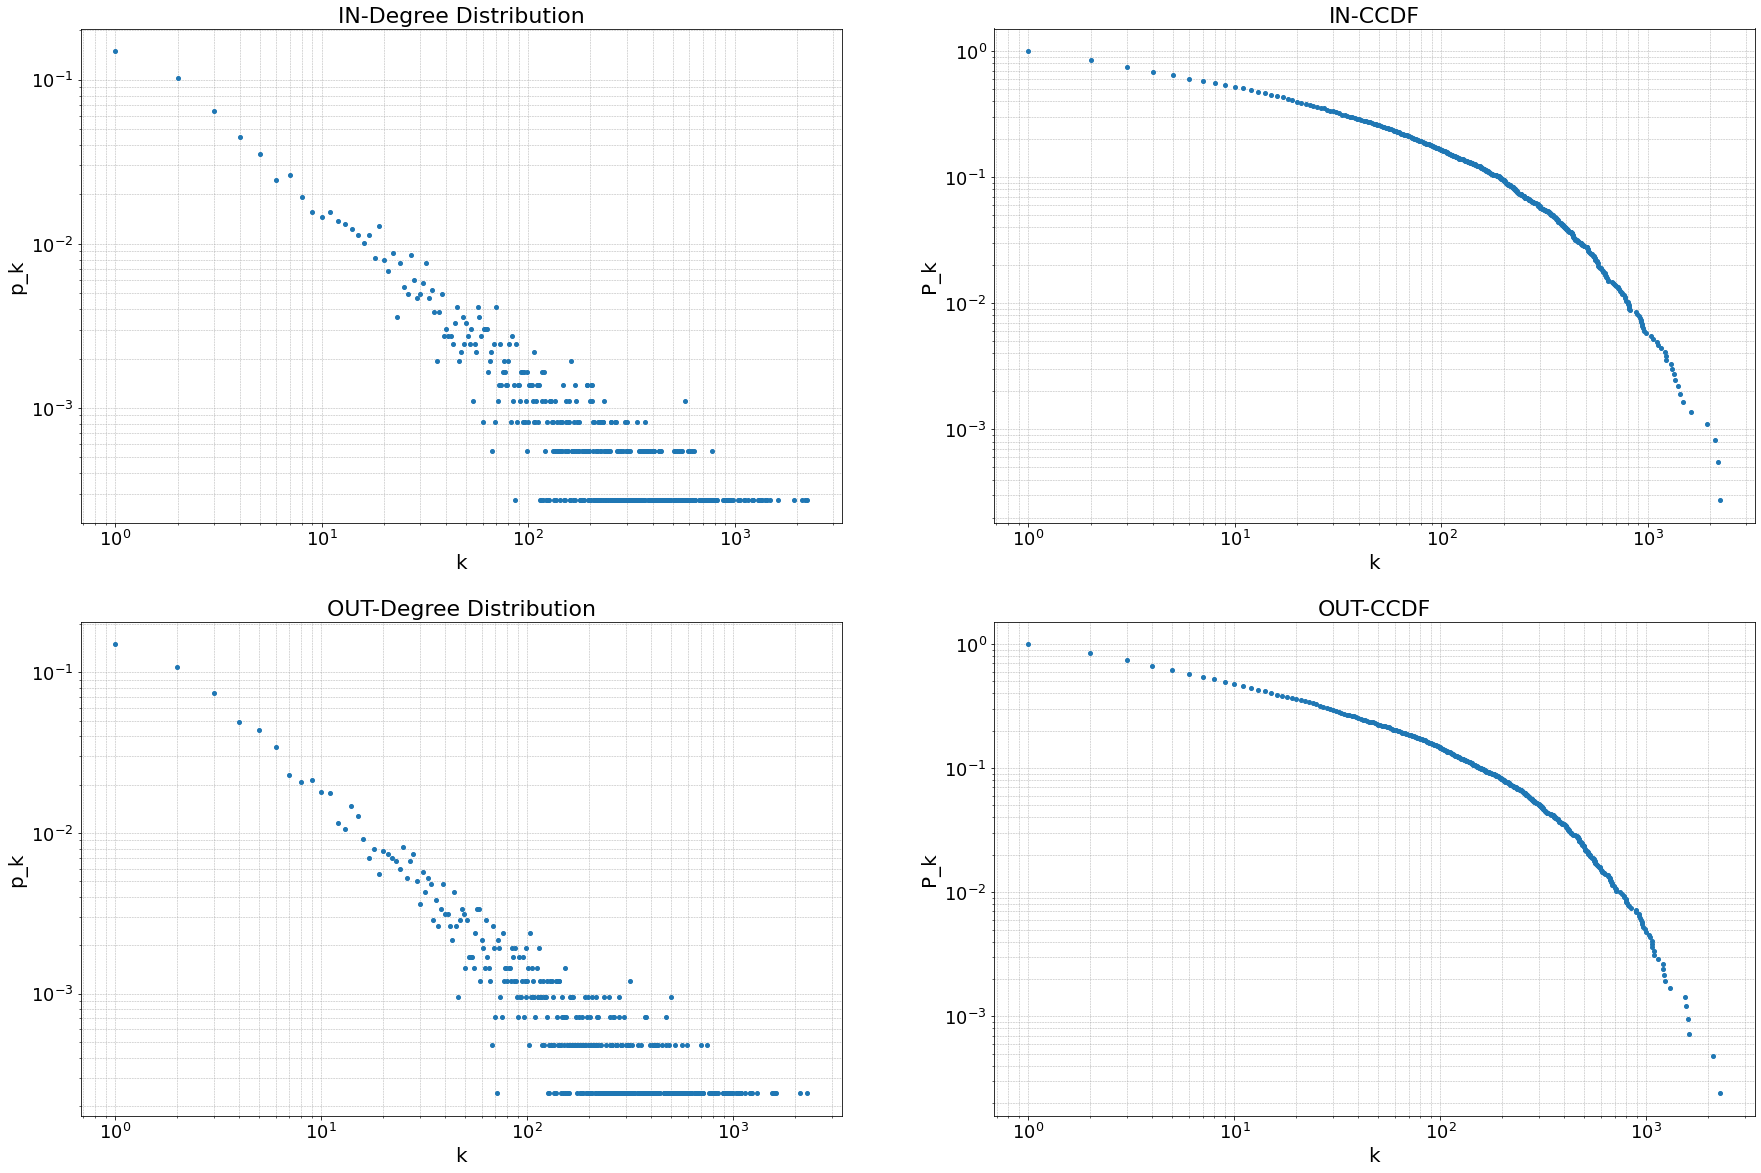

Top 10 for in degree


,Nodes,in degree
2096,UNIVERSITAT DE VALENCIA,2239
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2181
4099,UNIVERSIDADE DE LISBOA,2118
4660,UNIVERSIDAD DE GRANADA,1934
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,1615
4000,UNIVERZA V LJUBLJANI,1483
3800,UNIVERSITAT POLITECNICA DE VALENCIA,1436
2844,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1406
3615,UNIVERSIDAD DE SEVILLA,1352
438,KATHOLIEKE UNIVERSITEIT LEUVEN,1340


Top 10 for out degree


,Nodes,out degree
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
4660,UNIVERSIDAD DE GRANADA,2114
2096,UNIVERSITAT DE VALENCIA,1604
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
3586,UNIVERSITA DEGLI STUDI DI PADOVA,1563
1344,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
3038,UNIVERSITA DEGLI STUDI DI TORINO,1299
4099,UNIVERSIDADE DE LISBOA,1230
438,KATHOLIEKE UNIVERSITEIT LEUVEN,1218
4978,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1206


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

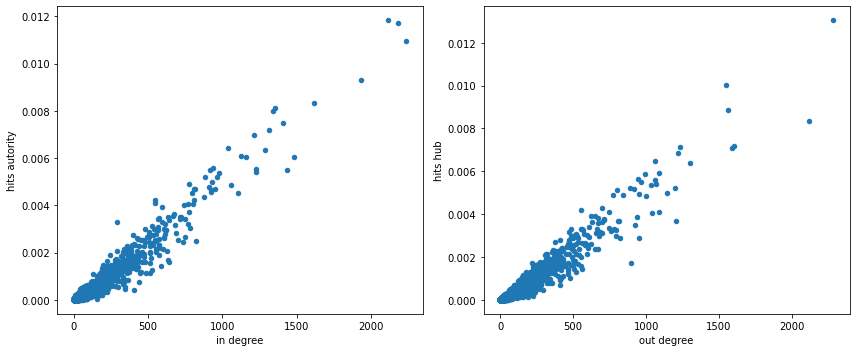

Top 10 for hits hub


,Nodes,hits hub
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013047
1344,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010031
3586,UNIVERSITA DEGLI STUDI DI PADOVA,0.008867
4660,UNIVERSIDAD DE GRANADA,0.008333
2096,UNIVERSITAT DE VALENCIA,0.007195
4099,UNIVERSIDADE DE LISBOA,0.007115
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007102
438,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006871
4100,TECHNISCHE UNIVERSITAET MUENCHEN,0.006476
3038,UNIVERSITA DEGLI STUDI DI TORINO,0.006369


Top 10 for hits autority


,Nodes,hits autority
4099,UNIVERSIDADE DE LISBOA,0.011827
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011717
2096,UNIVERSITAT DE VALENCIA,0.010963
4660,UNIVERSIDAD DE GRANADA,0.009295
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008322
3615,UNIVERSIDAD DE SEVILLA,0.008102
438,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007990
2844,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007498
986,UNIVERZITA KARLOVA,0.007183
2016,UNIVERSITAT DE BARCELONA,0.006963


In [12]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

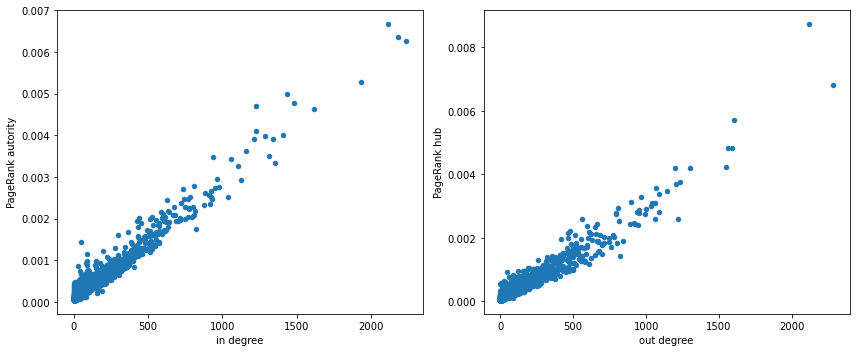

Top 10 for PageRank hub


,Nodes,PageRank hub
4660,UNIVERSIDAD DE GRANADA,0.008725
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006796
2096,UNIVERSITAT DE VALENCIA,0.005714
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004827
3586,UNIVERSITA DEGLI STUDI DI PADOVA,0.004826
1344,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004224
4364,UNIVERSIDAD POLITECNICA DE MADRID,0.004187
3038,UNIVERSITA DEGLI STUDI DI TORINO,0.004185
4099,UNIVERSIDADE DE LISBOA,0.003747
4978,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.003685


Top 10 for PageRank autority


,Nodes,PageRank autority
4099,UNIVERSIDADE DE LISBOA,0.006671
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006370
2096,UNIVERSITAT DE VALENCIA,0.006260
4660,UNIVERSIDAD DE GRANADA,0.005291
3800,UNIVERSITAT POLITECNICA DE VALENCIA,0.004998
4000,UNIVERZA V LJUBLJANI,0.004764
2515,POLITECNICO DI MILANO,0.004715
3133,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004639
3586,UNIVERSITA DEGLI STUDI DI PADOVA,0.004098
2844,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.004002


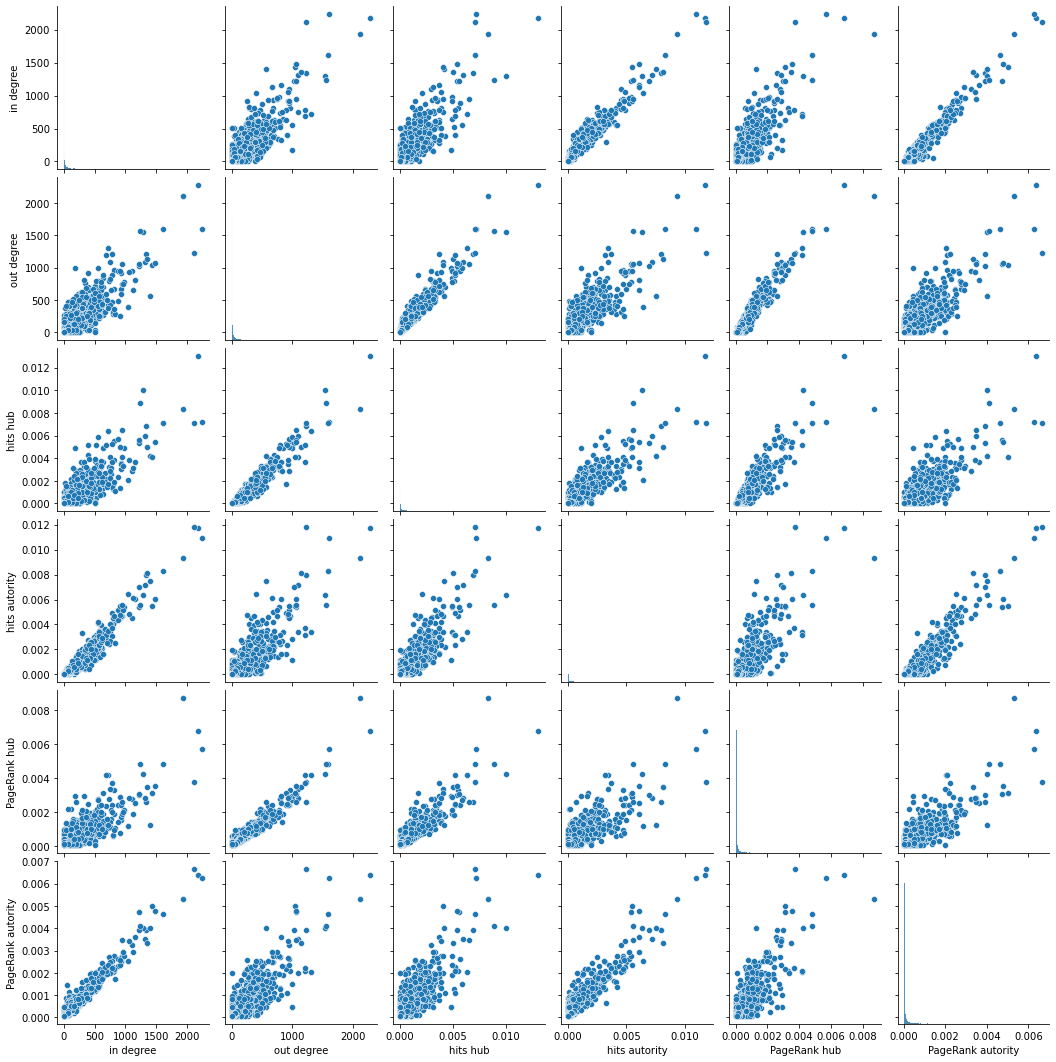

In [13]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

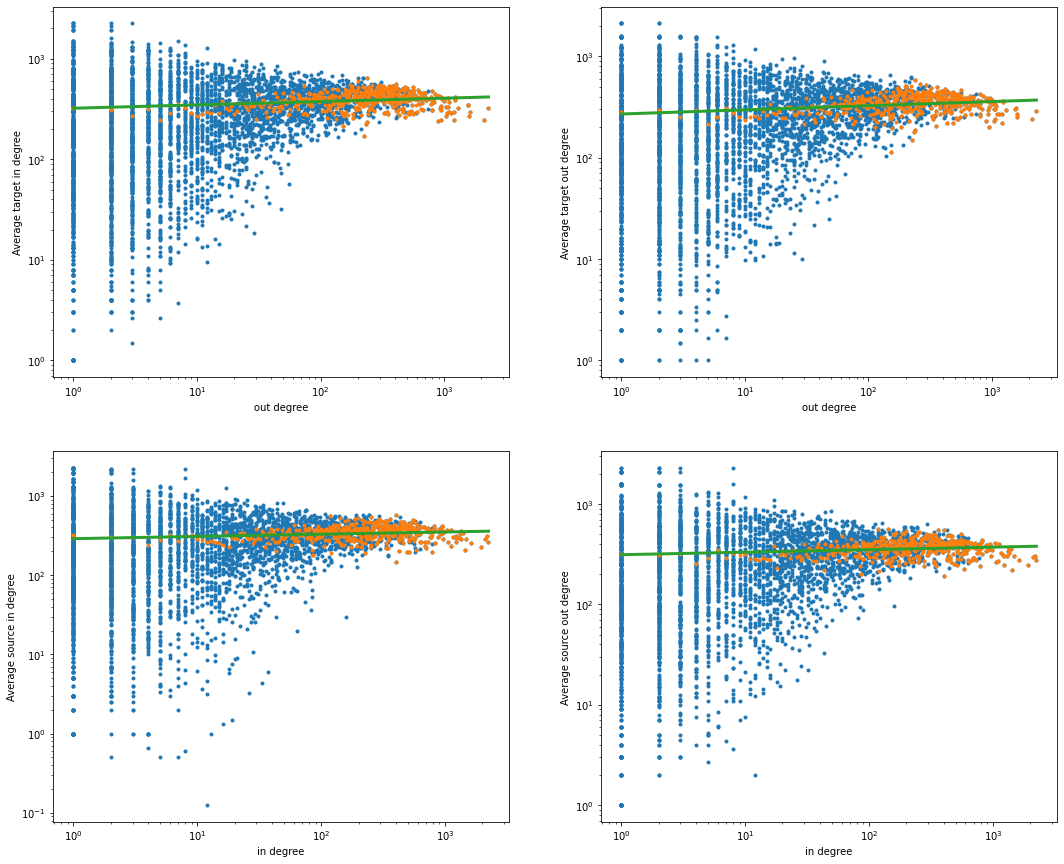

(0.03328336726379369,
 0.04089504568744987,
 0.028140315968197615,
 0.025142959029358692)

In [14]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Number of fields of education per university

In [15]:
Fields_serie_s = df_w_fields.groupby('Sending Organization')['Field of Education'].unique()
Fields_serie_r = df_w_fields.groupby('Receiving Organization')['Field of Education'].unique()
d = {'sending': Fields_serie_s, 'receiving': Fields_serie_r}
Fields_df = pd.DataFrame(d)
Fields_df


,sending,receiving
"""ADA"" UNIVERSITY","[sociology and cultural studies, business and ...","[political sciences and civics, arts and human..."
"""FINANCIAL ACADEMY""",[economics],NaN
"""KATHOLISCHE STIFTUNGSHOCHSCHULE MÜNCHEN"" HOCHSCHULE FÜR ANGEWANDTE WISSENSCHAFTEN DER KIRCHLICHEN STIFTUNG DES ÖFFENTLICHEN RECHTS ""KATHOLISCHE BILDUNGSSTÄTTEN FÜR SOZIALBERUFE IN BAYERN""","[nursing and midwifery, social work and counse...","[education, social work and counselling, child..."
"""KROK"" UNIVERSITY","[law, marketing and advertising]",[business and administration]
''FRENCH UNIVERSITY IN ARMENIA'' FOUNDATION,"[economics, law, management and administration]",NaN
...,...,...
ÜSKÜDAR UNIVERSITY,"[psychology, political sciences and civics, bi...","[welfare, psychology]"
РОССИЙСКАЯ АКАДЕМИЯ НАРОДНОГО ХОЗЯЙСТВА И ГОСУДАРСТВЕННОЙ СЛУЖБЫ ПРИ ПРЕЗИДЕНТЕ РОССИЙСКОЙ ФЕДЕРАЦИИ,[political sciences and civics],NaN
РОССИЙСКИЙ ГОСУДАРСТВЕННЫЙ АГРАРНЫЙ УНИВЕРСИТЕТ - МСХА ИМЕНИ К.А. ТИМИРЯЗЕВА,[economics],[transport services]
УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ УНИВЕРСИТЕТ,[political sciences and civics],NaN


In [16]:
Fields_df = Fields_df.fillna(0) 
#se vi viene in mente un modo migliore per togliere gli NaN e fare l'unione dopo siete i benvenuti
#(non si può fare .fillna([]) purtroppo)
Fields_df['N Fields'] = 0
for i in range(Fields_df.shape[0]):
    s = set() if type(Fields_df['sending'][i])==int else set(Fields_df['sending'][i])
    r = set() if type(Fields_df['receiving'][i])==int else set(Fields_df['receiving'][i])
    Fields_df['N Fields'][i] = len(s | r)
Fields_df['N Fields'].sort_values()

<ipython-input-16-5216e527d0ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fields_df['N Fields'][i] = len(s | r)


MENOFIA UNIVERSITY                                             1
KUNGLIGA MUSIKHOGSKOLAN I STOCKHOLM                            1
KUNGL. MUSIKHÖGSKOLAN I STOCKHOLM                              1
KULOB BRANCH OF THE TECHNOLOGICAL UNIVERSITY OF TAJIKISTAN     1
KROK UNIVERSITY                                                1
                                                              ..
UNIVERSIDADE DO PORTO                                         79
ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA                  80
UNIVERSITA DEGLI STUDI DI PADOVA                              81
UNIVERSIDADE DE LISBOA                                        82
UNIVERZA V LJUBLJANI                                          89
Name: N Fields, Length: 5079, dtype: int64

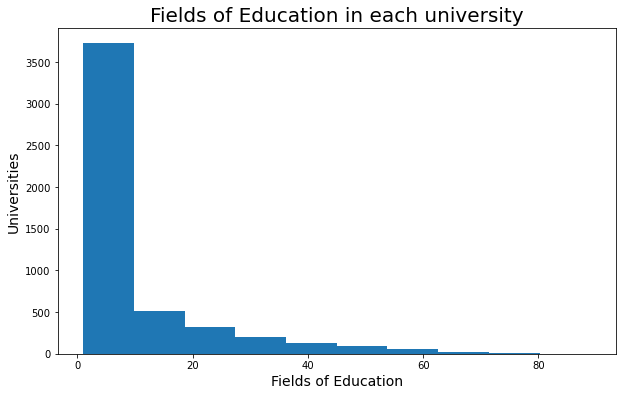

In [17]:
fig = plt.figure(figsize=(10,6))
plt.hist(Fields_df['N Fields'])
plt.xlabel('Fields of Education', size=14)
plt.ylabel('Universities', size=14)
plt.title('Fields of Education in each university', size=20)
plt.show()


In [18]:
Fields_df.drop(['sending', 'receiving'], axis=1, inplace=True)
Fields_df['Nodes'] = Fields_df.index

In [19]:
scores = pd.merge(scores, Fields_df, how='left', on='Nodes')
scores[['Nodes', 'N Fields']].sort_values(by='N Fields') # just to double check

,Nodes,N Fields
0,OLES GONCHAR DNIPROPETROVSK NATIONAL UNIVERSITY,1
2474,УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ УНИВЕРСИТЕТ,1
2471,SIR SYED UNIVERSITY OF ENGINEERINGAND TECHNOLOGY,1
2463,ARYABHATTA RESEARCH INSTITUTE OF OBSERVATIONAL...,1
2457,INSTITUT RÉGIONAL DE FORMATION SANITAIRE ET SO...,1
...,...,...
4015,UNIVERSIDADE DO PORTO,79
256,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,80
3586,UNIVERSITA DEGLI STUDI DI PADOVA,81
4099,UNIVERSIDADE DE LISBOA,82


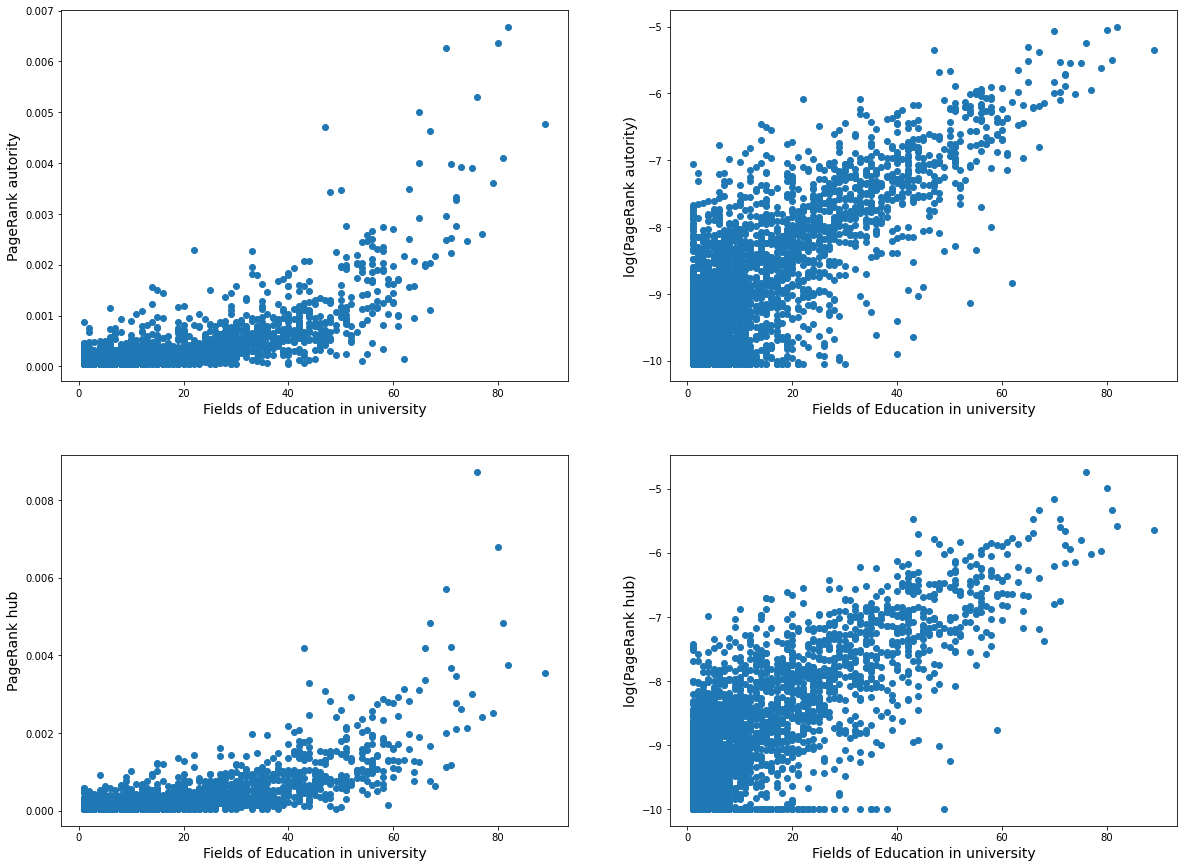

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0,0].scatter(scores['N Fields'], scores['PageRank autority'])
ax[0,0].set_xlabel('Fields of Education in university', size=14)
ax[0,0].set_ylabel('PageRank autority', size=14)

ax[0,1].scatter(scores['N Fields'], np.log(scores['PageRank autority']))
ax[0,1].set_xlabel('Fields of Education in university', size=14)
ax[0,1].set_ylabel('log(PageRank autority)', size=14)

ax[1,0].scatter(scores['N Fields'], scores['PageRank hub'])
ax[1,0].set_xlabel('Fields of Education in university', size=14)
ax[1,0].set_ylabel('PageRank hub', size=14)

ax[1,1].scatter(scores['N Fields'], np.log(scores['PageRank hub']))
ax[1,1].set_xlabel('Fields of Education in university', size=14)
ax[1,1].set_ylabel('log(PageRank hub)', size=14)

plt.show()


The centrality of a university seems to be exponential in the number of fields of education present in the university